In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os

In [2]:
path1 = '/Users/kimtaehyeong/Desktop/01_앞면_윗니 오른쪽'
os.chdir(path1)
files1 = os.listdir(path1) # 파일 폴더명 반환

data = []
for file in files1:
    f = cv2.imread(file)
    data.append(f)


In [3]:
len(data)

2687

In [4]:
# train, test 나누기
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, 
                               test_size=0.15,
                               shuffle=True,
                               random_state=42)

In [5]:
print(len(train))
print(len(test))

2283
404


In [6]:
# Train outlier data load
path1 = '/Users/kimtaehyeong/Desktop/아웃라이어'
os.chdir(path1)
files1 = os.listdir(path1)

for file in files1:
    f = cv2.imread(file)
    train.append(f)

In [7]:
path2 = '/Users/kimtaehyeong/Desktop/테스트 이상치'
os.chdir(path2)
files2 = os.listdir(path2)

for file in files2:
    f = cv2.imread(file)
    test.append(f)

In [8]:
print('Train: ', len(train))
print('Test: ', len(test))

Train:  2287
Test:  410


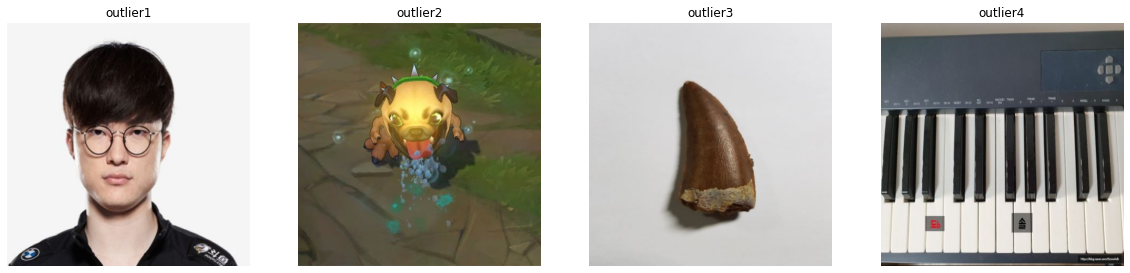

In [9]:
# Train 이상치
plt.figure(figsize=(20,8))

for i in range(1,5):
    plt.subplot(1,4,i)
    plt.imshow(cv2.cvtColor(train[-i], cv2.COLOR_BGR2RGB))
    plt.title(f'outlier{i}')
    plt.axis('off')
plt.show()

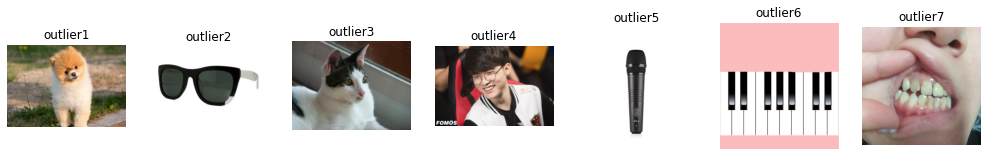

In [10]:
# test 이상치
plt.figure(figsize=(20,8))

for i in range(1,8):
    plt.subplot(1,8,i)
    plt.imshow(cv2.cvtColor(test[-i], cv2.COLOR_BGR2RGB))
    plt.title(f'outlier{i}')
    plt.axis('off')

plt.show()

In [11]:
# image resize
def image_resize(data_set, n_pixel):
    # create empty list
    resized_list = []
    # resize to n pixel 
    for i in range(len(data_set)):
        resized = cv2.resize(data_set[i], dsize=(n_pixel,n_pixel), interpolation=cv2.INTER_CUBIC)
        resized_list.append(resized)
        
    return resized_list

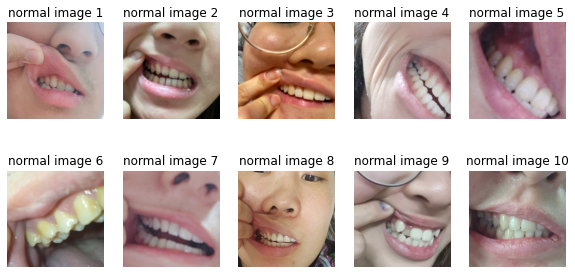

In [12]:
# 데이터 시각화
plt.figure(figsize = (10,5))

for i in range(1,10+1):
    plt.subplot(2,5,i)
    plt.imshow(cv2.cvtColor(train[i], cv2.COLOR_BGR2RGB))
    plt.title(f'normal image {i}')
    plt.axis('off')

In [13]:
train_resize_128 = image_resize(train, 128)

In [14]:
test_resize_128 = image_resize(test, 128)

In [15]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

In [16]:
train = np.array(train_resize_128)
test = np.array(test_resize_128)

test2 = test.copy()

In [17]:
# data normalization
train_normalization = train/255
test_normalization = test/255

In [18]:
model = keras.Sequential([
    keras.layers.Conv2D(4, kernel_size=(9,9), padding='same', activation='relu', 
                        input_shape=(128,128,3)),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(8, kernel_size=(5,5), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(16, kernel_size=(5,5), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(2048, activation='relu'),
    keras.layers.Dense(1024, activation='relu')
])

Metal device set to: Apple M1


2021-10-19 01:08:19.959846: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-19 01:08:19.959990: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 4)       976       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         808       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        3216      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        4

In [20]:
train_cnn = model.predict(train_normalization)
test_cnn = model.predict(test_normalization)

2021-10-19 01:08:21.108646: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-19 01:08:21.111658: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-10-19 01:08:21.171747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [21]:
print(train_cnn.shape)
print(test_cnn.shape)

(2287, 1024)
(410, 1024)


In [22]:
#MDS
from sklearn.manifold import MDS

mds = MDS(n_components=6, 
          dissimilarity='euclidean',
          metric = True,
          random_state=42)

train_data_mds = mds.fit_transform(train_cnn)
test_data_mds = mds.fit_transform(test_cnn)

<IPython.core.display.Javascript object>


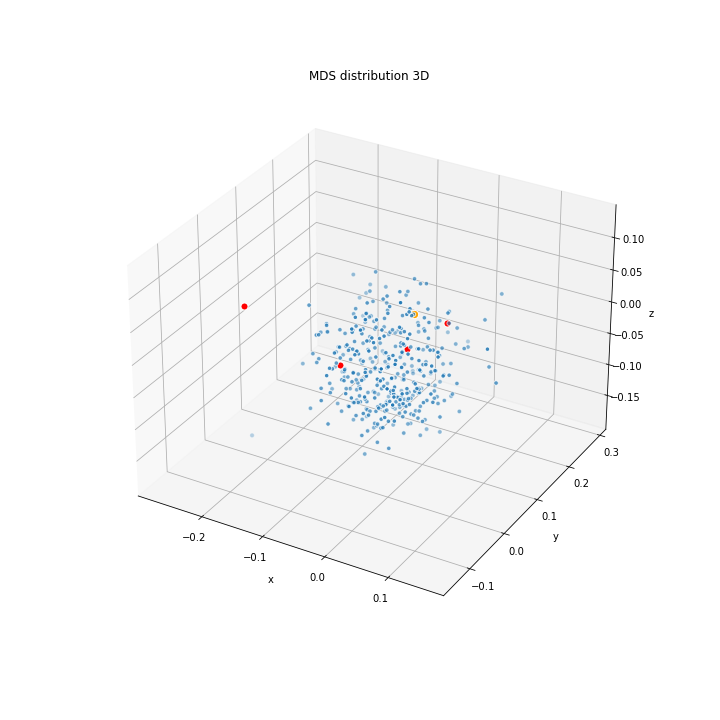

In [23]:
# visualize the test set distribution using pca
%matplotlib notebook

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

# normal data
ax.scatter(test_data_mds[:-6,0], test_data_mds[:-6,1], test_data_mds[:-6,2],
           s=20,
           edgecolor='white')
for i in range(1,5+1):
    ax.scatter(test_data_mds[-i,0], test_data_mds[-i,1], test_data_mds[-i,2],
               s=50,
               color='red',
               edgecolor='white')
ax.scatter(test_data_mds[-5,0], test_data_mds[-5,1], test_data_mds[-5,2],
           s=70,
           color='orange',
           edgecolor='white')
ax.set_title('MDS distribution 3D')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [24]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(n_estimators=500,
                          max_samples = 'auto', 
                          max_features=3,
                          contamination=0.002,
                          random_state=42)

iforest.fit(train_data_mds)
pred= iforest.predict(test_data_mds)

In [25]:
import pandas as pd

result = pd.DataFrame(pred, columns=['value'])

In [26]:
outlier = result[result.value==-1].index
outlier

Int64Index([404, 405, 408], dtype='int64')

<IPython.core.display.Javascript object>


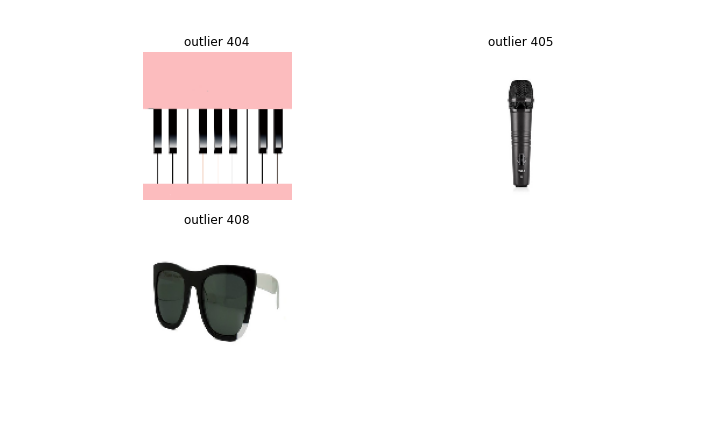

/var/folders/f4/fb3b_sqx3rvc3gfr73v6ck_00000gn/T/ipykernel_14319/2643789126.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(n,n,i+1)


In [27]:
plt.figure(figsize=(10,6))

for i in range(len(outlier)):
    n = np.ceil(np.sqrt(len(outlier)))
    plt.subplot(n,n,i+1)
    plt.imshow(cv2.cvtColor(test2[outlier[i]], cv2.COLOR_BGR2RGB))
    plt.title(f'outlier {outlier[i]}')
    plt.axis('off')
    
plt.show()